In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (11, 7)

## Import monthly data

Let's import `Inmet` data and create rolling variables to smooth quantities.

In [105]:
# import data

df = pd.read_csv('inmet_memp.csv', index_col=0)

df['yearmonth'] = pd.to_datetime(df['yearmonth'])

sinop = df[(df['dc_nome']=='sinop') & (df['yearmonth'] >= '2016-01-01')]

sinop.set_index('yearmonth', inplace=True)

train = sinop[(sinop.index >= '2016-01-01') & (sinop.index <= '2019-12-01')]

## Time series exploratory

Start of exploratory data analysis using time series framework.

In [4]:
import statsmodels.api as sm

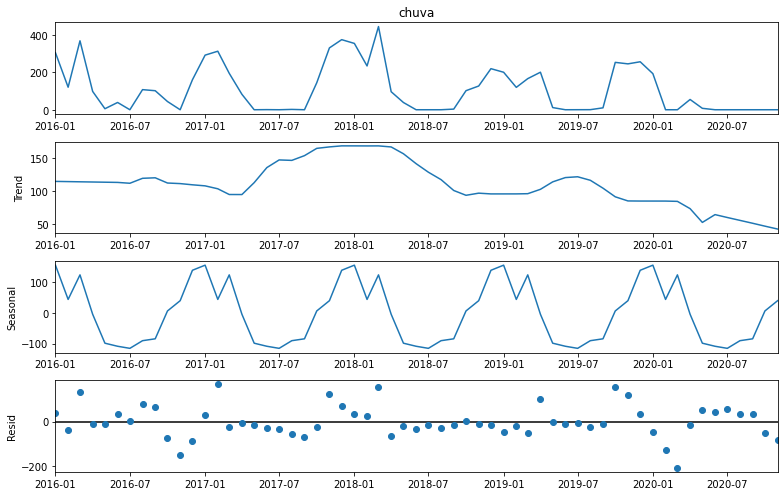

In [8]:
# time series decomposition

res = sm.tsa.seasonal_decompose(sinop.chuva, period=12, extrapolate_trend='freq')
resplot = res.plot()

#int(sinop.shape[0]/2)

In [9]:
# check for stationarity (ADF)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

res_adf = adfuller(sinop.chuva)
res_kpss = kpss(sinop.chuva)

print('----- ADF -----')
print('\nADF Statistic: %f' % res_adf[0])
print('p-value: %f' % res_adf[1])
print('Critical Values:')
for key, value in res_adf[4].items():
	print('\t%s: %.3f' % (key, value))
    

print('\n----- KPSSS -----')    
print('\nKPSS Statistic: %f' % res_kpss[0])
print('p-value: %f' % res_kpss[1])
print('Lags used: %d' %res_kpss[2])
print('Critical Values:')
for key, value in res_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

----- ADF -----

ADF Statistic: -4.422097
p-value: 0.000271
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595

----- KPSSS -----

KPSS Statistic: 0.385795
p-value: 0.083278
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


## Sarimax model

In [10]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions


In [11]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

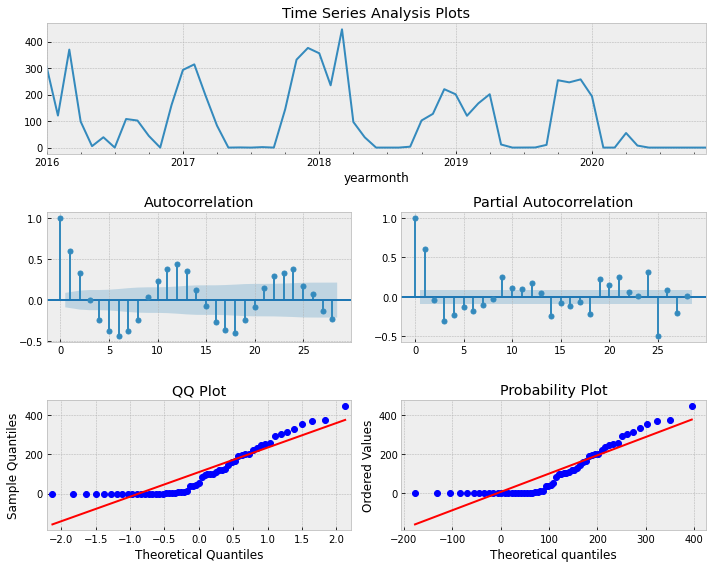

In [13]:
# plot ACF / PACF for series

tsplot(sinop.chuva, lags=28)

## SARIMA

Run `Sarima` w/ fixed parameters

In [131]:
# parameters

def run_sarima(p,d,q,P,D,Q,s):

    model = sm.tsa.statespace.SARIMAX(train.chuva, order=(p, d, q), 
                                                seasonal_order=(P, D, Q, s)).fit(disp=-1)

    aic = model.aic
    
    return model, aic

model_1 = run_sarima(1,0,1,1,0,1,12)
model_2 = run_sarima(4,0,4,2,0,1,12)
model_3 = run_sarima(4,0,4,2,0,2,12)

/Users/rodrigobraga/envs/jp-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rodrigobraga/envs/jp-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rodrigobraga/envs/jp-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rodrigobraga/envs/jp-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rodrigobraga/envs/jp-env/lib/python3.9/si

In [121]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    #data['arima_model'][:s+d] = np.NaN
    data['arima_model'][:d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    #error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error = skm.mean_absolute_error(data['actual'][d:], data['arima_model'][d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(sinop.chuva, label="actual")
    plt.legend()
    plt.grid(True);
    
    return forecast

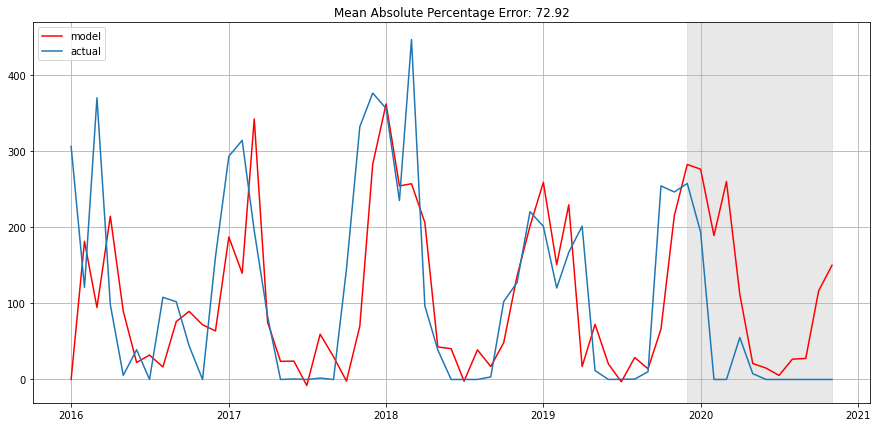

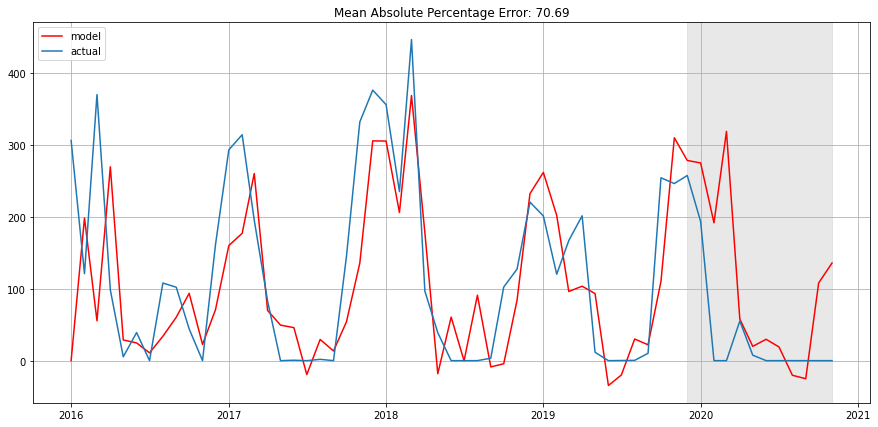

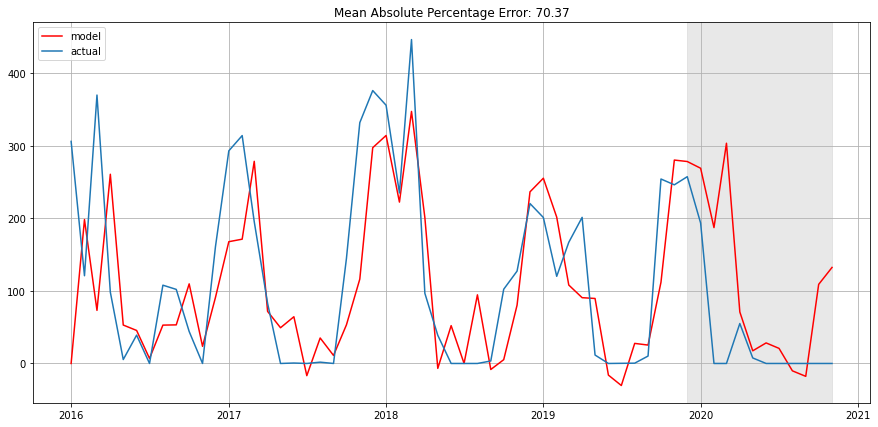

In [133]:
forecast_1 = plotSARIMA(pd.DataFrame(train.chuva), model_1[0], 10)
forecast_2 = plotSARIMA(pd.DataFrame(train.chuva), model_2[0], 10)
forecast_3 = plotSARIMA(pd.DataFrame(train.chuva), model_3[0], 10)

In [136]:
def plt_sarima(forecast, title):
    
    plt.title(title)

    plt.plot(sinop.chuva,
             label='actual')

    plt.plot(forecast,
             color='red',
             linestyle='--',
             label='model')

    '''
    plt.scatter(x=forecast.index,
                y=forecast-sinop.chuva,
                c='r',
                s=50,
                alpha=0.7)
    '''
    plt.fill_between(x=sinop.chuva.index,
                     y1=sinop.chuva,
                     y2=forecast,
                     alpha=0.3,
                     color=['tab:orange'],
                     hatch='///')

    plt.axvspan('2020-01-01', '2020-11-01', alpha=0.5, color='lightgrey')

    plt.legend()

    plt.grid()

    plt.savefig('SARIMA_sinop.png', bbox_inches='tight', facecolor='white')

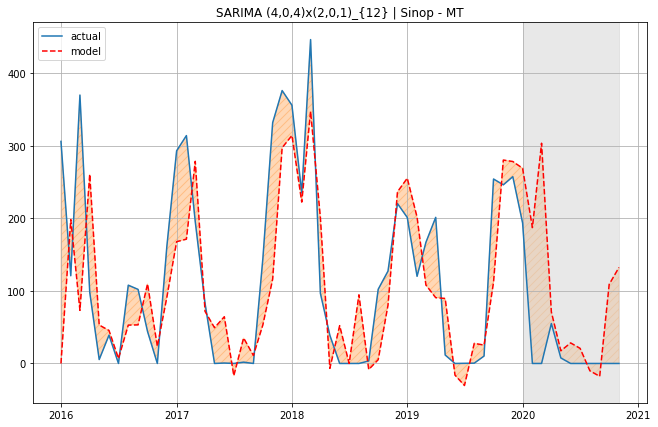

In [137]:
plt_sarima(forecast_3, 'SARIMA (4,0,4)x(2,0,1)_{12} | Sinop - MT')

In [138]:
skm.mean_absolute_error(sinop.chuva,forecast_3)

72.66913816424537

## Optmization

Try to find optimal parameters by iteration

In [95]:
# setting initial values and some bounds for them
ps = range(2, 5)
ds=range(0,2)
qs = range(2, 5)
Ps = range(2, 5)
Ds=range(0,2)
Qs = range(2, 5)
s = 12 # season length is 12

# creating list with all the possible combinations of parameters
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

324

In [26]:
def optimizeSARIMA(series,parameters_list, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(fdiff,parameters_list, s)

In [ ]:
result_table

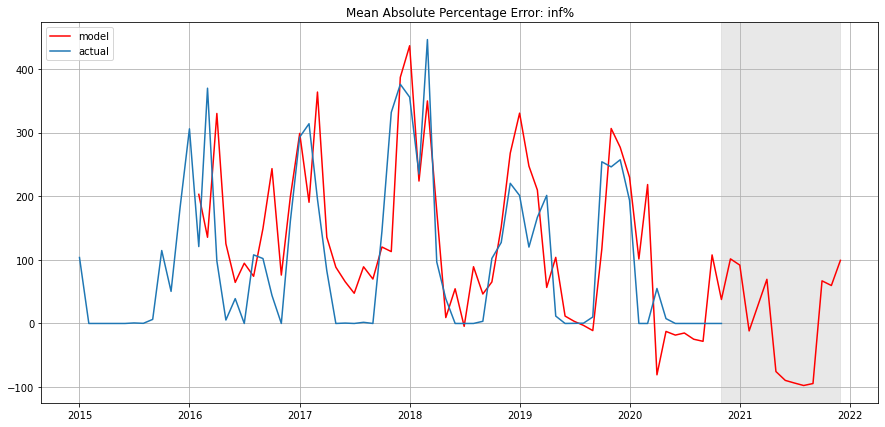

In [54]:
plotSARIMA(pd.DataFrame(fdiff), best_model, 12)